### Overfitting

In this notebook we demonstrate the effects of overfitting and show some techniques to combat it. We will be using a CNN-based binary classifier on the famous [cat vs dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

#### Dataset

Let's very briefly inspect the dataset.

Cats 2
Dogs 1


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


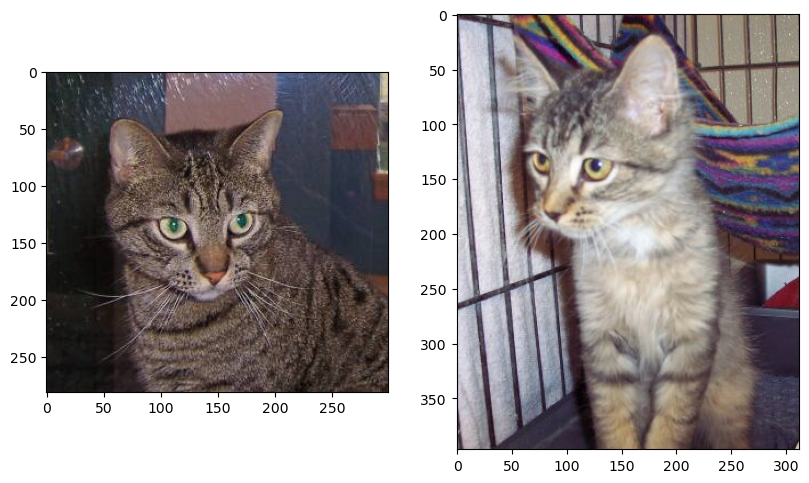

In [4]:
#folder = '/media/janko/DATA/Datasets/cats_dogs/train'
folder = 'C:\\Users\\STOIANOV\\cv-study\\lesson15\\cats_vs_dogs\\'
samples = os.listdir(folder)

print('Cats', len([s for s in samples if 'cat' in s]))
print('Dogs', len([s for s in samples if 'dog' in s]))

img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(132), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(133), plt.imshow(img)

Now it is the time to load the data. We will normalize the dimensions to a specific image size.

In [ ]:
size = 64
x, y = [], []

for sample in tqdm(samples):
    img = cv2.cvtColor(cv2.imread(os.path.join(folder, sample)), cv2.COLOR_BGR2RGB)
    if 
    img = cv2.resize(img, (size, size))
    x.append(img)
    if 'cat' in sample:
        y.append(0)
    elif 'dog' in sample:
        y.append(1)
    else:
        raise ValueError()

Let's split the data into training and validation subsets and normalize the pixel values.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape, len(y_train))

### Dog vs Cat Classification

We will start by building a simple CNN-based binary classifier.

In [ ]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
net = Dense(128, activation="relu")(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

And let's start training ;-)

In [ ]:
epochs = 50
batch_size = 64

print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

This experiment suffers from a considerable overfitting (the training loss and accuracy are far better than the validation performance). We need to apply some of the techniques seen in the lectures to combat this effect.

### Regularizations

To reduce the negative effect of overfitting, we will insert droput layers after each convolution and before the last fully connected layer. Furthermore, we reduce the size of the dense layer after flatten. Note that reducing the network complexity is also a form of regularization.

In [ ]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dense(64, activation="relu")(net)
net = Dropout(0.5)(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

In [ ]:
epochs = 50
batch_size = 64

print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
plot_history(history)

The results look better now but there is still a significat performance gap between training and validation.

### Data Augmentation

As a next step, data augmentation is applied. We build a data generator and, in this simple example, we will add the so called *mirroring* as the only augmentation technique. In general, there is a large variety of augmentation you can experiment with (gamma correction, adding noise, blurring, sharpening, brightness modification, color (un)balancing, etc.).

Note that data augmentation is applied only to training data.

In [ ]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.5:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                    
            yield x_, y_

In [ ]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dense(64, activation="relu")(net)
net = Dropout(0.5)(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

In [ ]:
epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
plot_history(history)

The results look much better now. Even though the training accuracy is lower than before, the important thing is that validation performance has increased and is above 90% of accuracy now. We can further experiment with different (more complex) architectures and more complex data augmentators.